## Problem description:
Lagrangian
$$
L=\sum_i \frac{m_i}{2}(\dot{x_i}^2 + \dot{y_i}^2) + \sum_i \sum_j \frac{Gm_im_j}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}}
$$
and Hamiltonian
$$
H=p\dot{q}-L
$$
$$
\dot{q_i} = \frac{\partial H}{\partial p_i},    \space
\dot{p_i} = -\frac{\partial H}{\partial q_i}  
$$


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
x0 = np.array([
    # Initial momenta (px1, py1, px2, py2, px3, py3)
    -0.93240737/2, -0.86473146/2,   # p1
    -0.93240737/2, -0.86473146/2,   # p2
    0.93240737, 0.86473146,         # p3
    
    # Initial positions (x1, y1, x2, y2, x3, y3)
    0.97000436, -0.24308753,        # r1
    -0.97000436, 0.24308753,        # r2
    0.0, 0.0                        # r3
])

# Simulation parameters
G = 1.0  # Gravitational constant
t = np.linspace(0, 10, 1000)  # Time span
dt = t[1] - t[0]  # Time step

In [36]:
def Ham(x):
    # x is now [px1,py1,px2,py2,px3,py3, x1,y1,x2,y2,x3,y3]
    # Kinetic Energy for all planets
    T = (x[0]*x[0] + x[1]*x[1])/2 + (x[2]*x[2] + x[3]*x[3])/2 + (x[4]*x[4] + x[5]*x[5])/2
    
    # Potential Energy between all pairs
    r12 = np.sqrt((x[6]-x[8])**2 + (x[7]-x[9])**2)   # distance between 1-2
    r13 = np.sqrt((x[6]-x[10])**2 + (x[7]-x[11])**2) # distance between 1-3
    r23 = np.sqrt((x[8]-x[10])**2 + (x[9]-x[11])**2) # distance between 2-3
    
    V = -G/r12 - G/r13 - G/r23
    return T + V

def f(x):
    # Calculate all pairwise forces
    r12 = np.sqrt((x[6]-x[8])**2 + (x[7]-x[9])**2)
    r13 = np.sqrt((x[6]-x[10])**2 + (x[7]-x[11])**2)
    r23 = np.sqrt((x[8]-x[10])**2 + (x[9]-x[11])**2)
    
    # Momentum equations (dp/dt = -∂H/∂q)
    dp1x = -G*(x[6]-x[8])/r12**3 - G*(x[6]-x[10])/r13**3
    dp1y = -G*(x[7]-x[9])/r12**3 - G*(x[7]-x[11])/r13**3
    
    dp2x = -G*(x[8]-x[6])/r12**3 - G*(x[8]-x[10])/r23**3
    dp2y = -G*(x[9]-x[7])/r12**3 - G*(x[9]-x[11])/r23**3
    
    dp3x = -G*(x[10]-x[6])/r13**3 - G*(x[10]-x[8])/r23**3
    dp3y = -G*(x[11]-x[7])/r13**3 - G*(x[11]-x[9])/r23**3
    
    # Position equations (dq/dt = ∂H/∂p)
    dx1 = x[0]  # px1
    dy1 = x[1]  # py1
    dx2 = x[2]  # px2
    dy2 = x[3]  # py2
    dx3 = x[4]  # px3
    dy3 = x[5]  # py3
    
    return [dp1x,dp1y,dp2x,dp2y,dp3x,dp3y, dx1,dy1,dx2,dy2,dx3,dy3]

def Euler(t, x0, dt, n):
    x = np.zeros((n+1,12))  # Now 12 dimensions
    H = np.zeros(n+1)
    x[0] = x0
    H[0] = Ham(x[0])
    
    for i in range(1, n+1):  
        x[i] = x[i-1] + dt * np.array(f(x[i-1]))
        H[i] = Ham(x[i])
                                       
    return x, H


In [37]:
def midpoint(t, x0, dt, n):
    x = np.zeros((n+1,12))  # Changed to 12 dimensions
    H = np.zeros(n+1)
    x[0] = x0
    H[0] = Ham(x[0])
    
    for i in range(1, n+1):
        # Calculate midpoint state
        x_half = x[i-1] + 0.5 * dt * np.array(f(x[i-1]))
        
        # Use midpoint state to calculate full step
        x[i] = x[i-1] + dt * np.array(f(x_half))
        
        # Calculate energy at new state
        H[i] = Ham(x[i])
        
    return x, H

First order symplectic: 
$$
q_i = q_{i-1} + dt \cdot \frac{\partial H}{\partial p_{i-1}}
$$

where the differential is equal to the velocity, therefore this updates the position 

$$
p_i = p_{i-1} + dt \cdot -\frac{\partial H}{\partial q_{i-1}}
$$


In [38]:
def symplectic1(t, x0, dt, n):
    x = np.zeros((n+1,12))  # Changed to 12 dimensions
    H = np.zeros(n+1)
    x[0] = x0
    H[0] = Ham(x[0])
    
    for i in range(1, n+1):
        # Update positions first (all three bodies)
        ff = np.array(f(x[i-1]))
        x[i,6:12] = x[i-1,6:12] + dt * ff[6:12]  # Positions: indices 6-11
        
        # Update momenta second (all three bodies)
        ff = np.array(f(x[i]))
        x[i,0:6] = x[i-1,0:6] + dt * ff[0:6]     # Momenta: indices 0-5

        H[i] = Ham(x[i])
    
    return x, H

In [39]:
def symplectic2(t, x0, dt, n, ite=20, tol=1e-12):
    x = np.zeros((n+1,12), dtype=np.float64)  # Changed to 12 dimensions
    H = np.zeros(n+1, dtype=np.float64)
    x[0] = x0
    H[0] = Ham(x[0])
    
    for i in range(1, n+1):
        # Initial guess using explicit Euler
        x[i] = x[i-1] + dt * np.array(f(x[i-1]))
        
        # Iterative improvement
        k = 0
        err = 1.e6
        xn = x[i].copy()
        
        # Implicit midpoint iteration
        while k < ite and err > tol:
            # Update using midpoint value
            x[i] = x[i-1] + dt * np.array(f((x[i-1] + x[i])/2.))
            
            # Calculate error for convergence check
            err = np.linalg.norm(x[i] - xn)
            
            # Store current value for next iteration
            xn = x[i].copy()
            k = k + 1
            #print(k, "==", err)
            
        H[i] = Ham(x[i])
    
    return x, H

# Example usage:
"""
# Simulation parameters
t = np.linspace(0, 20, 2000)
dt = t[1] - t[0]
iterations = 10     # Maximum iterations for implicit solve
tolerance = 1e-12   # Convergence tolerance

# Run simulation
x, H = symplectic2(t, x0, dt, len(t)-1, iterations, tolerance)
"""

'\n# Simulation parameters\nt = np.linspace(0, 20, 2000)\ndt = t[1] - t[0]\niterations = 10     # Maximum iterations for implicit solve\ntolerance = 1e-12   # Convergence tolerance\n\n# Run simulation\nx, H = symplectic2(t, x0, dt, len(t)-1, iterations, tolerance)\n'

In [41]:
def plot_method(x, H):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    # 1. Orbital paths plot
    ax1 = fig.add_subplot(221)
    ax1.plot(x[:,6], x[:,7], 'r-', label='Body 1', alpha=0.5)  # Body 1
    ax1.plot(x[:,8], x[:,9], 'b-', label='Body 2', alpha=0.5)  # Body 2
    ax1.plot(x[:,10], x[:,11], 'g-', label='Body 3', alpha=0.5)  # Body 3
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Orbital Paths')
    ax1.grid(True)
    ax1.legend()
    ax1.set_aspect('equal')

    # 2. Energy conservation plot
    ax2 = fig.add_subplot(222)
    ax2.plot(t, H, 'k-')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Total Energy')
    ax2.set_title('Energy Conservation')
    ax2.grid(True)

    # 3. Momentum plot
    ax3 = fig.add_subplot(223)
    ax3.plot(t, x[:,0], 'r-', label='px1', alpha=0.5)
    ax3.plot(t, x[:,1], 'r--', label='py1', alpha=0.5)
    ax3.plot(t, x[:,2], 'b-', label='px2', alpha=0.5)
    ax3.plot(t, x[:,3], 'b--', label='py2', alpha=0.5)
    ax3.plot(t, x[:,4], 'g-', label='px3', alpha=0.5)
    ax3.plot(t, x[:,5], 'g--', label='py3', alpha=0.5)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Momentum')
    ax3.set_title('Momentum Components')
    ax3.grid(True)
    ax3.legend()

    # 4. Relative distances plot
    r12 = np.sqrt((x[:,6]-x[:,8])**2 + (x[:,7]-x[:,9])**2)
    r13 = np.sqrt((x[:,6]-x[:,10])**2 + (x[:,7]-x[:,11])**2)
    r23 = np.sqrt((x[:,8]-x[:,10])**2 + (x[:,9]-x[:,11])**2)

    ax4 = fig.add_subplot(224)
    ax4.plot(t, r12, 'r-', label='r12', alpha=0.5)
    ax4.plot(t, r13, 'b-', label='r13', alpha=0.5)
    ax4.plot(t, r23, 'g-', label='r23', alpha=0.5)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Distance')
    ax4.set_title('Relative Distances')
    ax4.grid(True)
    ax4.legend()

    plt.tight_layout()
    plt.show()

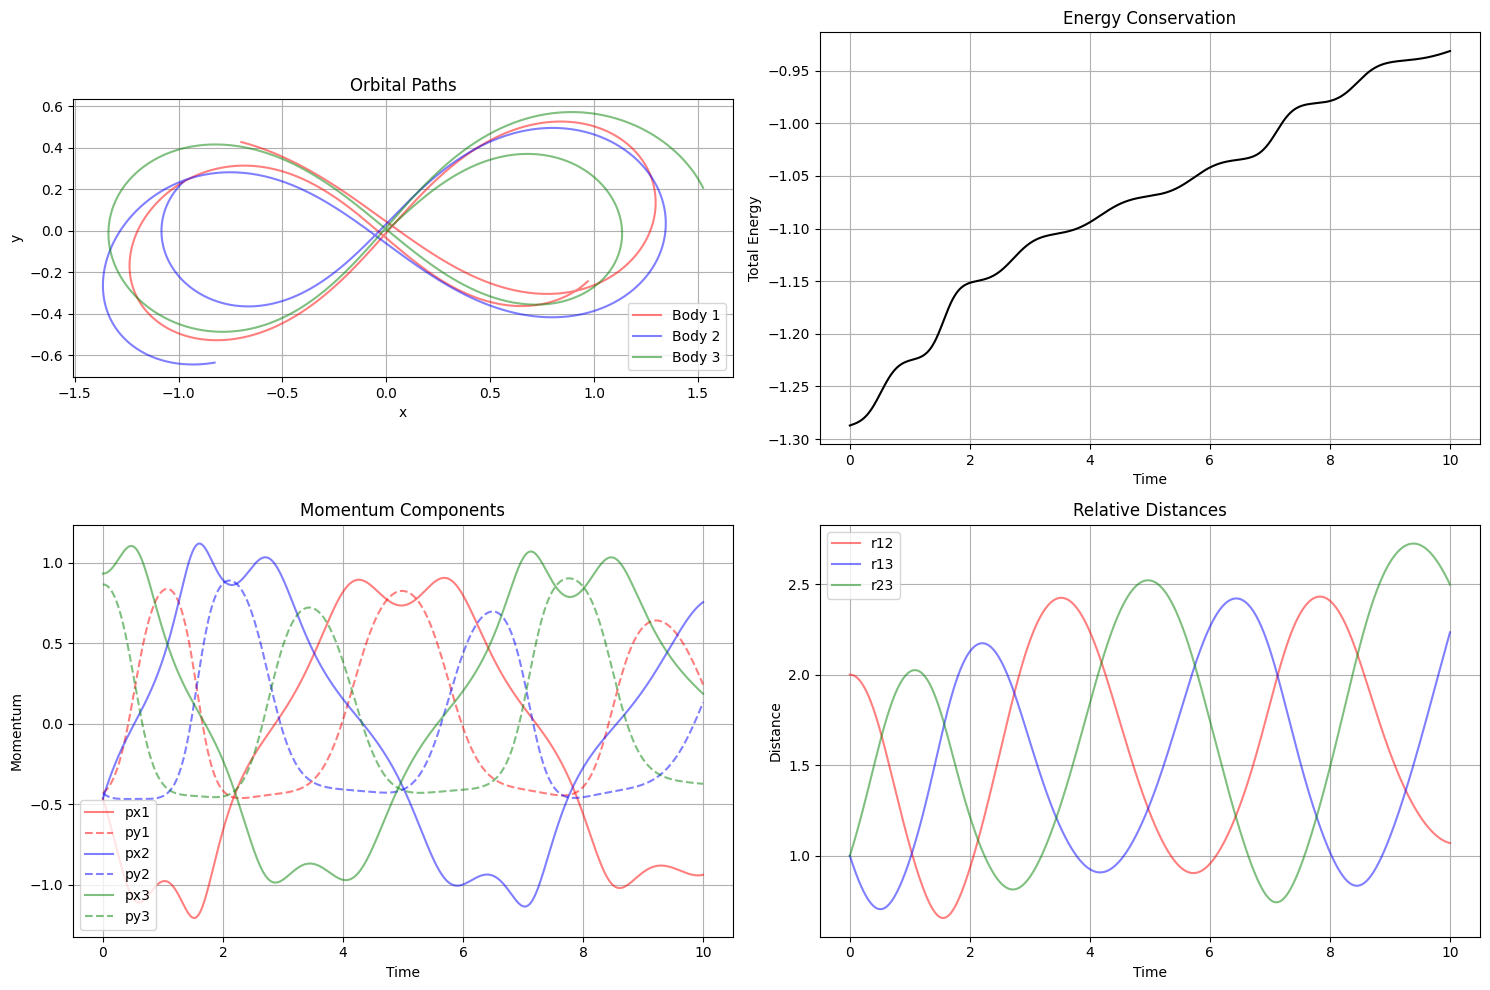

In [42]:
x, H = Euler(t, x0, dt, len(t)-1)

import matplotlib.pyplot as plt
plot_method(x, H)

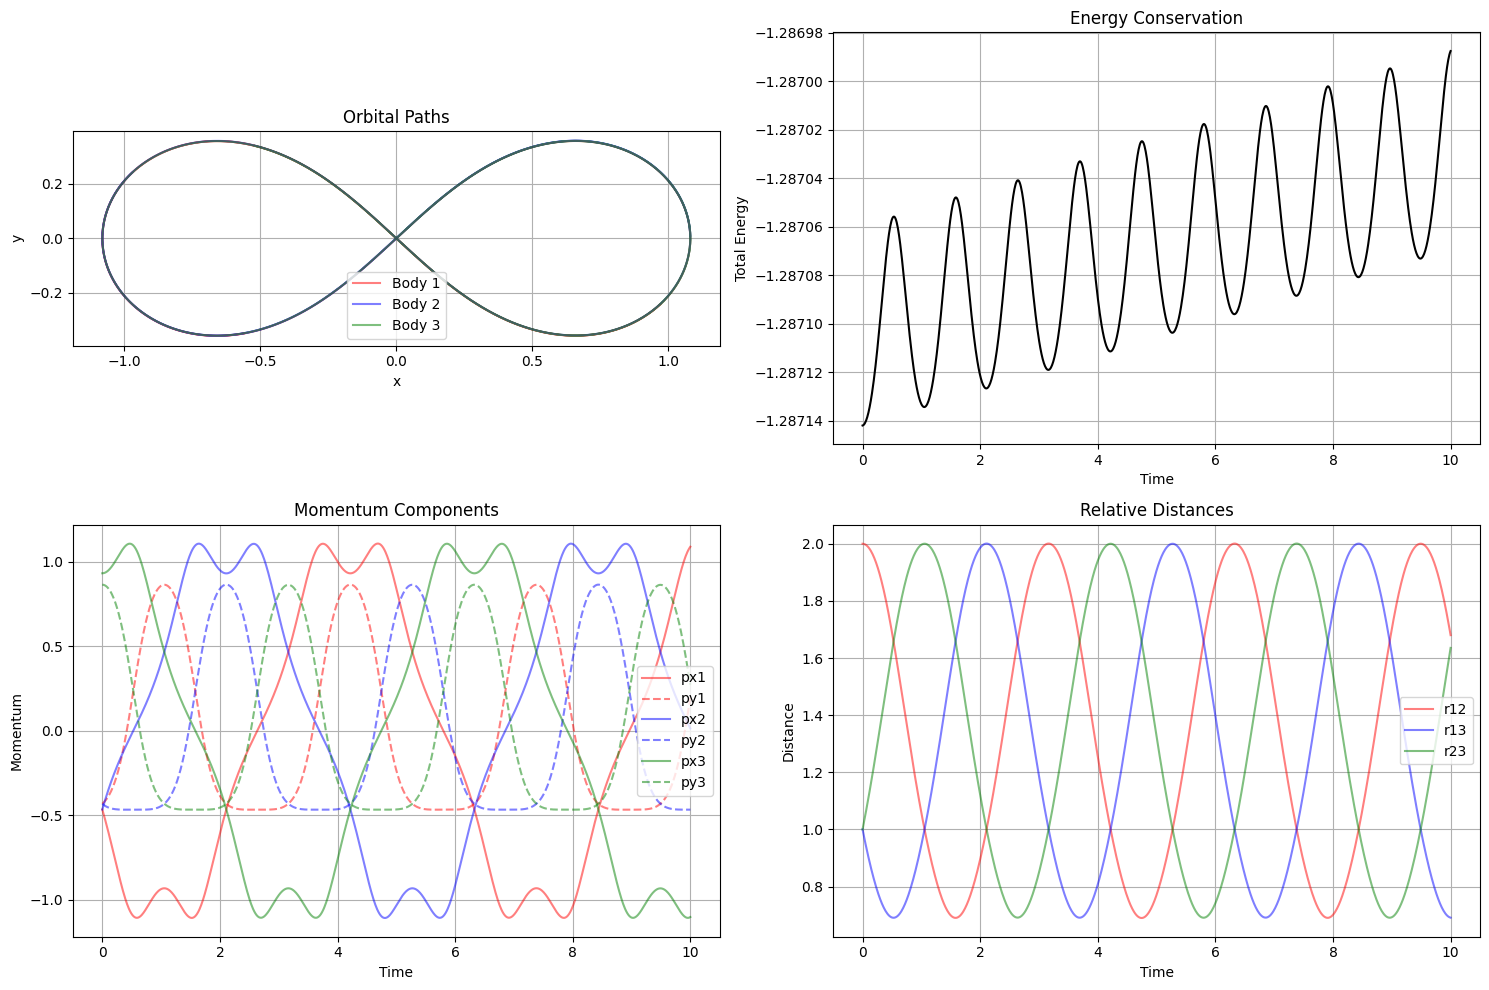

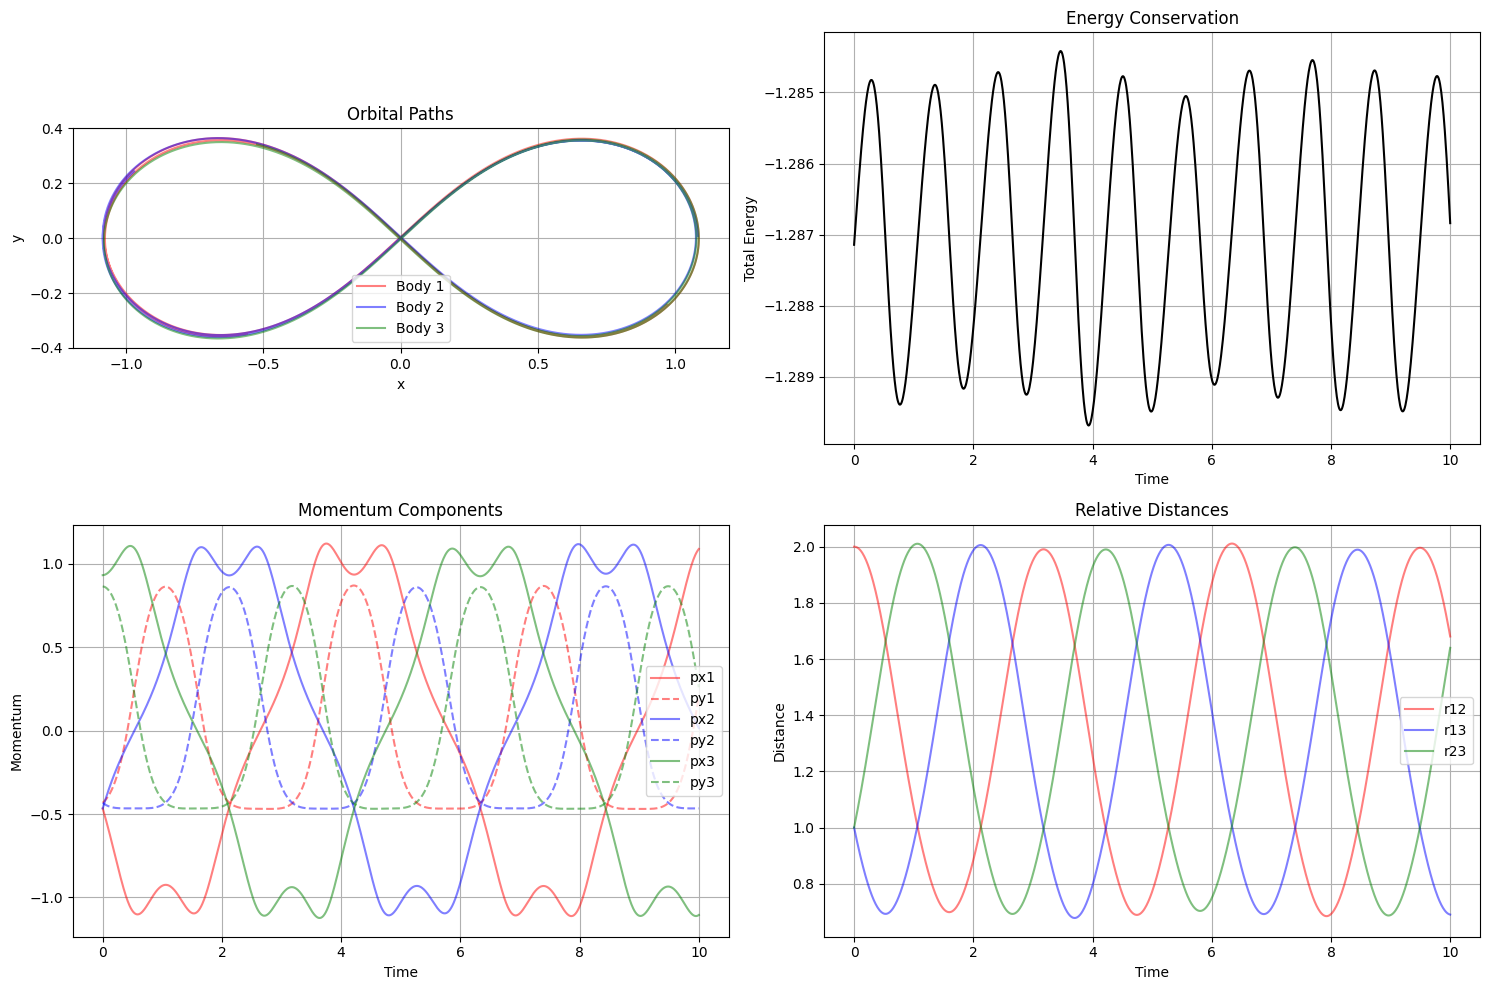

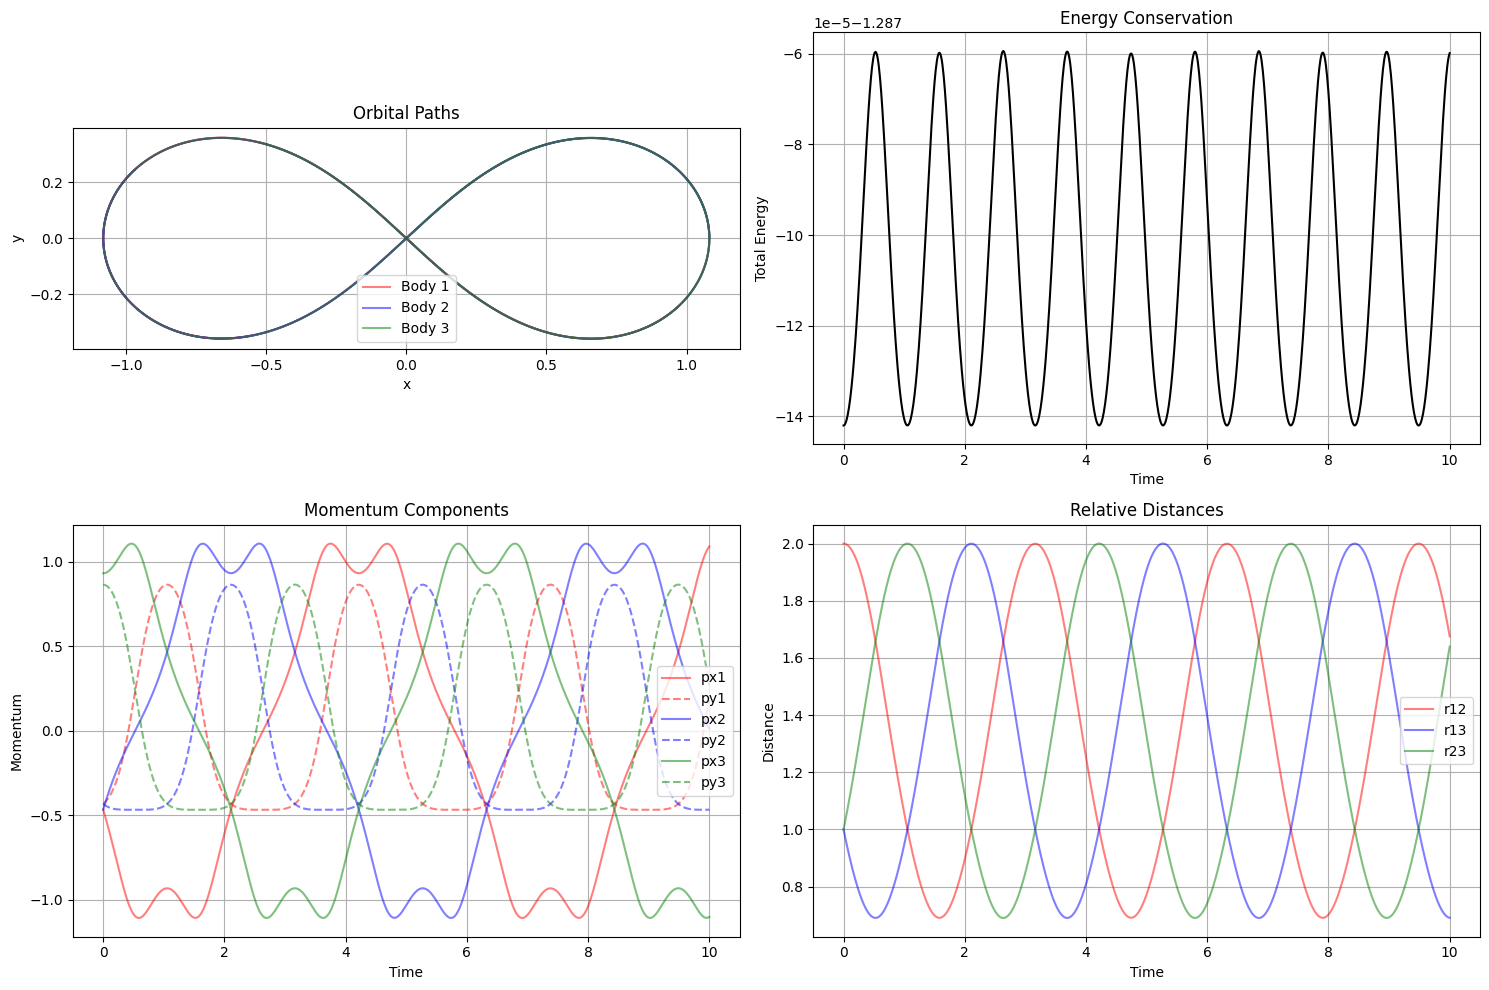

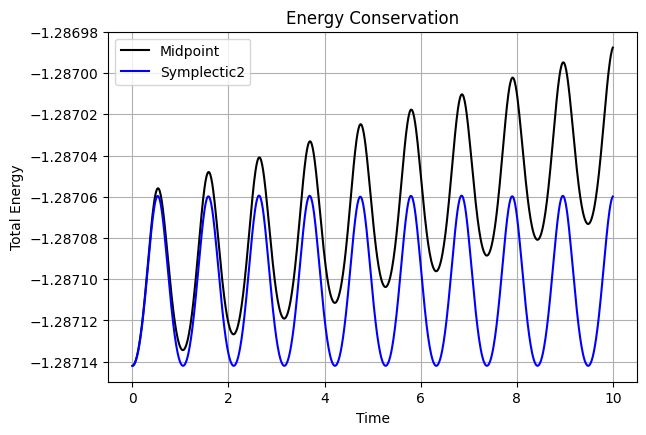

In [46]:
x, H = midpoint(t, x0, dt, len(t)-1)

plot_method(x, H)

x_symplectic1, H_symplectic1 = symplectic1(t, x0, dt, len(t)-1)

plot_method(x_symplectic1, H_symplectic1)


x_symplectic2, H_symplectic2 = symplectic2(t, x0, dt, len(t)-1)

plot_method(x_symplectic2, H_symplectic2)

fig = plt.figure(figsize=(15, 10))
 # 2. Energy conservation plot
ax2 = fig.add_subplot(222)
ax2.plot(t, H, 'k-', label="Midpoint")
#ax2.plot(t, H_symplectic1, '--r', label="Symplectic1")
ax2.plot(t, H_symplectic2, '-b', label="Symplectic2")
ax2.set_xlabel('Time')
ax2.set_ylabel('Total Energy')
ax2.set_title('Energy Conservation')
ax2.grid(True)
plt.legend(loc="upper left")
plt.show()